In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [3]:
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import imageio
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
eps = np.finfo(np.float32).eps.item()

In [5]:
env = gym.make('CartPole-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

observation space: Box(4,)
action space: Discrete(2)


In [ ]:
class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=32, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.action = nn.Linear(h_size, a_size)
        self.value = nn.Linear(h_size, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        action_score = self.action(x)
        state_value = self.value(x)
        return F.softmax(action_score, dim=1), state_value
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs, state_value = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action), state_value

In [ ]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

In [8]:
policy

Policy(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (action): Linear(in_features=32, out_features=2, bias=True)
  (value): Linear(in_features=32, out_features=1, bias=True)
)

In [9]:
def reinforce(n_episodes=10000, max_t=1000, gamma=0.99, print_every=100):
    scores = []
    losses = []
    for i_episode in range(1, n_episodes+1):
        memory = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob, state_value = policy.act(state)
            memory.append((log_prob, state_value))
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores.append(sum(rewards))
        
        new_rewards = []
        R = 0
        for r in rewards[::-1]:
            R = r + gamma * R
            new_rewards.insert(0, R)

        new_rewards = torch.tensor(new_rewards)
        new_rewards = (new_rewards - new_rewards.mean()) / (new_rewards.std() + eps)

        # discounts = [gamma**i for i in range(len(rewards)+1)]
        # R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        value_loss = []
        for (log_prob, state_value), r in zip(memory, new_rewards):
            reward = r - state_value.item()
            policy_loss.append(-log_prob * reward)
            value_loss.append(F.smooth_l1_loss(state_value, torch.tensor([r])))

        loss = torch.stack(policy_loss).sum() + torch.stack(value_loss).sum()
        
        losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores[-100:])))
        if np.mean(scores[-100:])>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores[-100:])))
            break
        
    return scores, losses
    
scores, losses = reinforce()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Episode 100	Average Score: 37.29
Episode 200	Average Score: 147.83
Episode 300	Average Score: 170.65
Episode 400	Average Score: 173.98
Episode 500	Average Score: 180.28
Episode 600	Average Score: 185.82
Environment solved in 531 episodes!	Average Score: 195.32


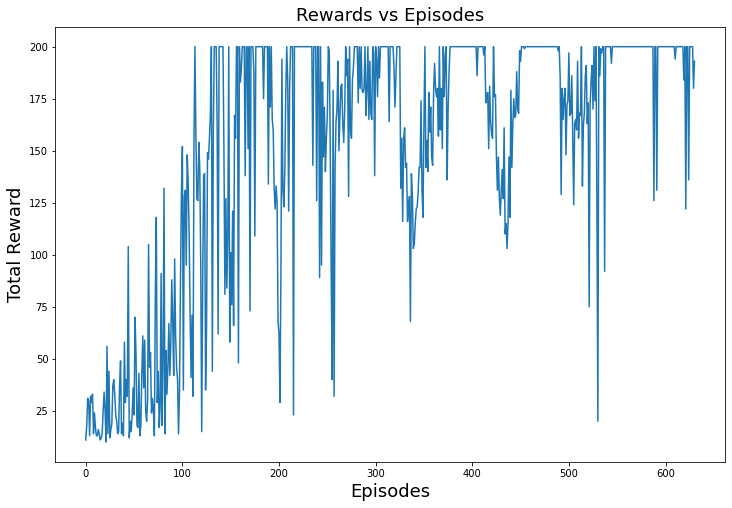

In [10]:
plt.figure(figsize=(12,8))
plt.title('Rewards vs Episodes', fontsize = 18)
plt.xlabel('Episodes', fontsize = 18)
plt.ylabel('Total Reward', fontsize=18)
plt.plot(scores)

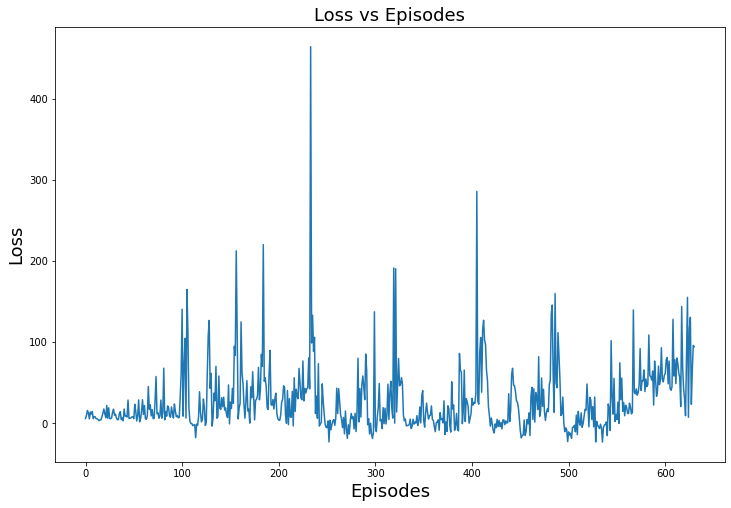

In [11]:
plt.figure(figsize=(12,8))
plt.title('Loss vs Episodes', fontsize = 18)
plt.xlabel('Episodes', fontsize = 18)
plt.ylabel('Loss', fontsize=18)
plt.plot(losses)

In [ ]:
path = f"/content/gdrive/My Drive/ModelFiles/"
env = gym.make('CartPole-v0')
rewards = 0
state = env.reset()
frames_for_gif = []
frames_for_gif.append(env.render(mode='rgb_array'))
for t in range(1000):
    action, _, _ = policy.act(state)

    frame = env.render(mode='rgb_array')
    frames_for_gif.append(frame)
    # print (reward)
    # ipythondisplay.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    rewards += reward
    if done:
        break 

imageio.mimsave(f'{path}{"ATARI_CARTPOLE_A2C_reward_{0}.gif".format(rewards)}', 
                    frames_for_gif, duration=1/30)

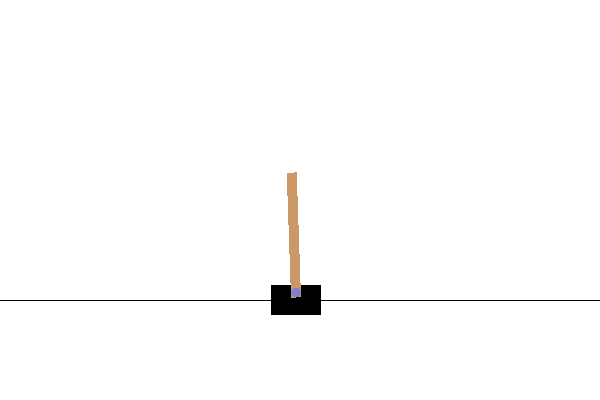

In [13]:
from IPython.display import Image
from IPython import display
animatedGif = f"{path}ATARI_CARTPOLE_A2C_reward_200.0.gif" #path relative to your notebook
file = open(animatedGif , "rb")
image = file.read()
progress= Image(image)
display.display(progress)